### ANALYSIS OF THE ACCIDENT DATA

In [141]:
# Import Relevant Library
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from itertools import product
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

import folium
from folium.plugins import MarkerCluster
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score

In [34]:
# Connect to the SQLite database
con = sqlite3.connect("accident_data_v1.0.0_2023.db")
cur= con.cursor()

### Data Joining and Extraction in Database

In [35]:
# Excute SQl command to Join tables in the uk database
data= pd.read_sql("""
SELECT *
FROM accident
LEFT JOIN vehicle ON accident.accident_index = vehicle.accident_index
LEFT JOIN casualty ON accident.accident_index = casualty.accident_index
LEFT JOIN lsoa ON accident.lsoa_of_accident_location = lsoa.lsoa01cd
WHERE accident.accident_year IN (2017, 2018, 2019)
""", con) 

### Preprocessing

In [36]:
# Remove Duplicated Columns
data = data.loc[:, ~data.columns.duplicated()]


# Copy data to a new variable to preserve original for reference purpose
acc_data= data.copy()

# Further drop non-essential or redundant columns with high correlation
acc_data=acc_data[['accident_index', 'vehicle_reference', 'casualty_reference', 'accident_year','longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_ons_district', 'first_road_class',
       'road_type', 'speed_limit', 'junction_detail',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'vehicle_type', 'towing_and_articulation',
       'vehicle_manoeuvre', 'vehicle_direction_from', 'vehicle_direction_to', 'junction_location',
       'skidding_and_overturning', 'hit_object_off_carriageway',
       'first_point_of_impact','journey_purpose_of_driver', 'sex_of_driver', 'age_of_driver',
       'age_band_of_driver', 'engine_capacity_cc', 'propulsion_code',
       'age_of_vehicle', 'generic_make_model', 'driver_imd_decile',
       'driver_home_area_type', 'casualty_class', 'sex_of_casualty', 'age_of_casualty',
       'age_band_of_casualty', 'casualty_severity', 'pedestrian_location',
       'pedestrian_movement', 'car_passenger', 'bus_or_coach_passenger',
       'pedestrian_road_maintenance_worker', 'casualty_type',
       'casualty_home_area_type', 'casualty_imd_decile',
       'lsoa01nm',
       ]]

In [37]:
# Combine date and time and convert to datetime format
acc_data['date'] = acc_data['date'] + ' ' + acc_data['time']

# Convert the combined string to datetime
acc_data['date'] = pd.to_datetime(acc_data['date'], format='%d/%m/%Y %H:%M')

#### Cleaning 

In [43]:
'''
Pandas exploratory tool such as value_count and matplotlib visualisation tool were used to detect
most appropriate tool to fill the missing values. Otherwise, columns were converted to NaN
'''

ped_mode=acc_data['pedestrian_crossing_human_control'].mode()
acc_data['pedestrian_crossing_human_control']=acc_data['pedestrian_crossing_human_control'].replace((-1,9),ped_mode[0])

ped_phy_mode= acc_data['pedestrian_crossing_physical_facilities'].mode()
acc_data['pedestrian_crossing_physical_facilities']=acc_data['pedestrian_crossing_physical_facilities'].replace((-1,9),ped_phy_mode[0])


light_con_mode= acc_data['light_conditions'].mode()
acc_data['light_conditions']=acc_data['light_conditions'].replace(-1,light_con_mode[0])


weather_con_mode= acc_data['weather_conditions'].mode()
acc_data['weather_conditions']=acc_data['weather_conditions'].replace(-1,weather_con_mode[0])


rd_con_mode= acc_data['road_surface_conditions'].mode()
acc_data['road_surface_conditions']=acc_data['road_surface_conditions'].replace((-1,9),rd_con_mode[0])

special_con_mode= acc_data['special_conditions_at_site'].mode()
acc_data['special_conditions_at_site']=acc_data['special_conditions_at_site'].replace((-1,9),special_con_mode[0])

carrway_haz_mode= acc_data['carriageway_hazards'].mode()
acc_data['carriageway_hazards']=acc_data['carriageway_hazards'].replace((-1,9),carrway_haz_mode[0])

pol_on_site_mode= acc_data['did_police_officer_attend_scene_of_accident'].mode()
acc_data['did_police_officer_attend_scene_of_accident']=acc_data['did_police_officer_attend_scene_of_accident'].replace((-1,3),pol_on_site_mode[0])

# Trunk road flag
trunk_rd_mode= acc_data['trunk_road_flag'].mode()
acc_data['trunk_road_flag']=acc_data['trunk_road_flag'].replace(-1,trunk_rd_mode[0])

vehicle_typ_mode= acc_data['vehicle_type'].mode()
acc_data['vehicle_type']=acc_data['vehicle_type'].replace((-1,99),vehicle_typ_mode[0])

towing_mode= acc_data['towing_and_articulation'].mode()
acc_data['towing_and_articulation']=acc_data['towing_and_articulation'].replace((-1,99),towing_mode[0])

manoeuvre_mode= acc_data['vehicle_manoeuvre'].mode()
acc_data['vehicle_manoeuvre']=acc_data['vehicle_manoeuvre'].replace((-1,99),manoeuvre_mode[0])


acc_data['vehicle_direction_from']=acc_data['vehicle_direction_from'].replace((-1,9,0),np.nan)
acc_data['vehicle_direction_to']=acc_data['vehicle_direction_to'].replace((-1,9,0),np.nan)
#acc_data['vehicle_direction_to'] = acc_data['vehicle_direction_to'].astype(pd.Int64Dtype())



# JUNCTION CONTROL AND JUNCTION DETAILS CLEANING
# Convert -1,99 and 9 to misiing value(NaN) in both columns
acc_data['junction_location']=acc_data['junction_location'].replace((-1,9),np.nan)
acc_data['junction_detail']=acc_data['junction_detail'].replace((-1,99),np.nan)

# Conditionally select junction details row that are nan but has junction control row to be 0( Do viceversal)
''' Given the definition of 0 in both junction_detail and junction_location, these two columns should ideally be 
   consistent for this specific value. That is, if an accident is identified as "not at a junction" in one column,
   it should be the same in the other'''
condition_1 = (acc_data['junction_detail'] == 0) & (acc_data['junction_location'].isna())
condition_2 = (acc_data['junction_location'] == 0) & (acc_data['junction_detail'].isna())

# Apply the fill operation using .loc for conditional assignment
acc_data.loc[condition_1, 'junction_location'] = 0
acc_data.loc[condition_2, 'junction_detail'] = 0

jour_purp_mode= acc_data['journey_purpose_of_driver'].mode()
acc_data['journey_purpose_of_driver']=acc_data['journey_purpose_of_driver'].replace((-1),jour_purp_mode[0])

acc_data['sex_of_driver']=acc_data['sex_of_driver'].replace(-1,3) #Just 8 -1 ######

# convert -1 in latitude and longitude to NaN
acc_data['latitude']=acc_data['latitude'].replace(-1,np.nan)
acc_data['longitude']=acc_data['longitude'].replace(-1,np.nan)

# Convert missing values and invalid entries to Nan
acc_data['urban_or_rural_area']=acc_data['urban_or_rural_area'].replace((-1,3),np.nan)

acc_data['speed_limit']=acc_data['speed_limit'].replace(-1,np.nan)

### Analysis

#### FETCH 2019 Accident Data

In [166]:
# Filter accidents from 2019 alone into a new variable
acc_data2019= acc_data[acc_data['accident_year'] == 2019].reset_index(drop=True)

#### E1
Are there any particular hours of the day, and days of the week, on which these accidents are 
more likely occur to a significant degree?

In [167]:
# Extract Hours of accident to a new column
acc_data2019['hour'] = acc_data2019['date'].dt.hour

# Filter unique accident reference. 
unique_acc2019_indexes=acc_data2019.groupby('accident_index').first()   # This remove the redundancy create due to one-many-joining

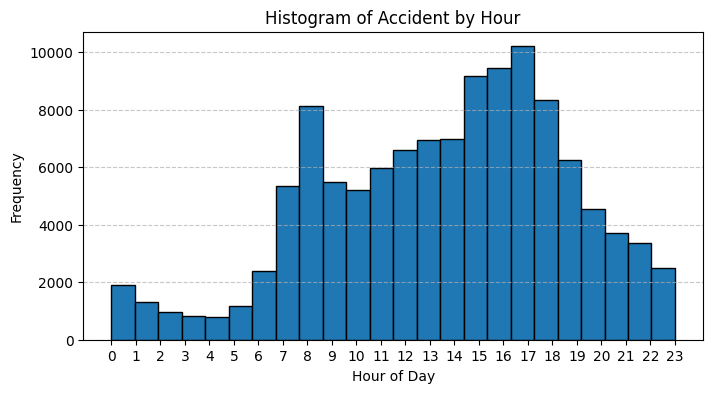

In [161]:
# PLot histogram of hourly accident rate
plt.figure(figsize=(8, 4))
plt.hist(unique_acc2019_indexes['hour'], bins=24, edgecolor='black')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Histogram of Accident by Hour')
plt.xticks(range(24))  # to show all 24 hours on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [150]:
# Perform Chi-test to check the significance of the pattern
hourly_counts = unique_acc2019_indexes.groupby('hour').size()
chisquare(hourly_counts)

Power_divergenceResult(statistic=41889.584263544784, pvalue=0.0)

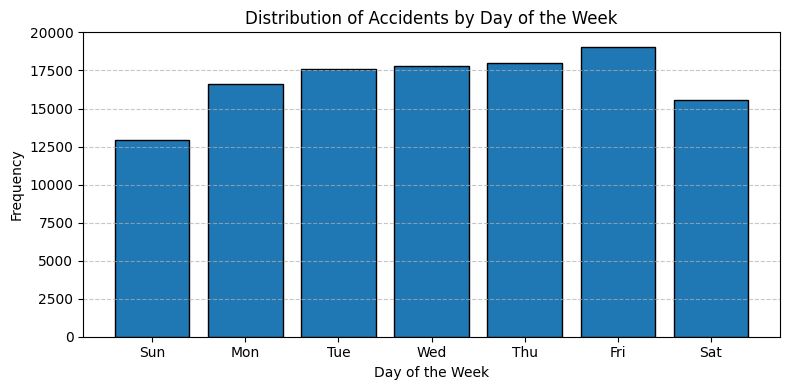

In [145]:
# Count how many accidents occurred on each day (assuming 1=Sunday, 7=Saturday or similar)
day_counts = unique_acc2019_indexes['day_of_week'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(day_counts.index, day_counts.values, edgecolor='black', align='center')
plt.xticks(ticks=range(1, 8), labels=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.xlabel('Day of the Week')
plt.ylabel('Frequency')
plt.title('Distribution of Accidents by Day of the Week')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


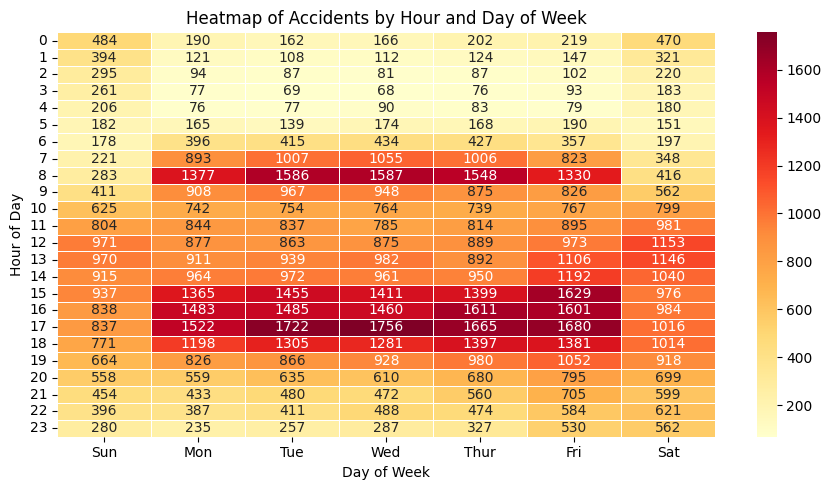

In [168]:
# Map numbers to weekday names
day_map = {1: 'Sun', 2: 'Mon',
           3: 'Tue', 4: 'Wed',
           5: 'Thur', 6: 'Fri',
           7: 'Sat'}

unique_acc2019_indexes['day_of_week'] = unique_acc2019_indexes['day_of_week'].map(day_map)

# Pivot table: rows=hour, columns=day of week, values=accident counts
pivot = unique_acc2019_indexes.pivot_table(
    index='hour',
    columns='day_of_week',
    aggfunc='size',
    fill_value=0
)

# Reorder the columns
ordered_days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat']
pivot = pivot[ordered_days]

# Plot heatmap with annotations
plt.figure(figsize=(9, 5))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=.5, annot=True, fmt='d')
plt.title('Heatmap of Accidents by Hour and Day of Week')
plt.ylabel('Hour of Day')
plt.xlabel('Day of Week')
plt.tight_layout()
plt.show()


##### Inspect light condition influence on hour of accident

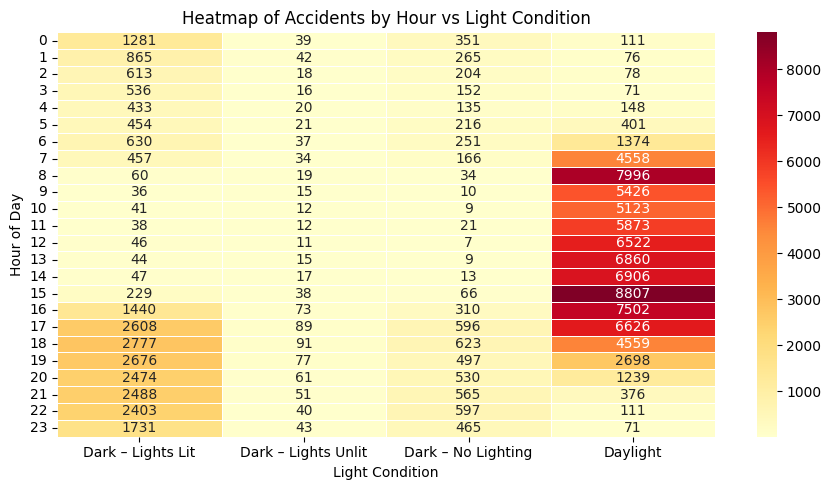

In [172]:
# Pivot table: rows=hour, columns=light condition
# mapping light conditions
light_conditions = {
    1: 'Daylight',
    4: 'Dark – Lights Lit',
    5: 'Dark – Lights Unlit',
    6: 'Dark – No Lighting'
}

light_heatm= unique_acc2019_indexes.copy()
# Map the numeric weather codes to words
light_heatm['light_text'] = light_heatm['light_conditions'].map(light_conditions)

# Create pivot table
pivot = light_heatm.pivot_table(
    index='hour',
    columns='light_text',
    aggfunc='size',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=.5, annot=True, fmt='d')
plt.title('Heatmap of Accidents by Hour vs Light Condition')
plt.ylabel('Hour of Day')
plt.xlabel('Light Condition')
plt.tight_layout()
plt.show()

##### Inspect weather condition influence

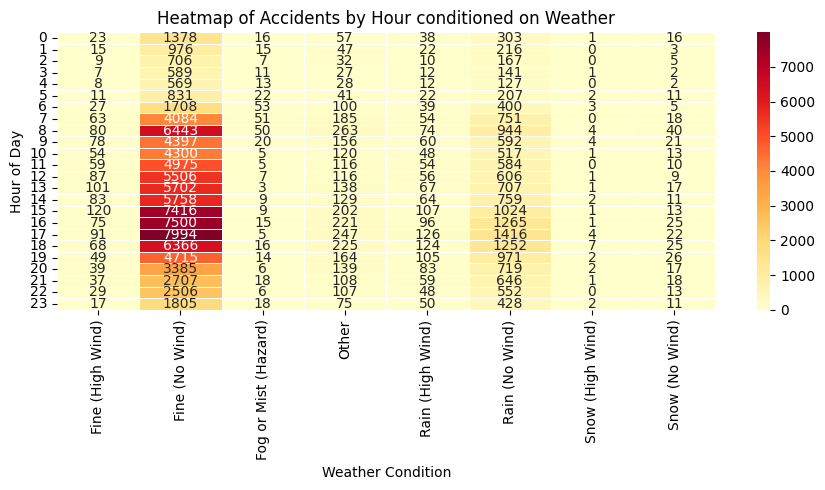

In [229]:
# Define weather condition codes and labels
weather_conditions = {
    1: 'Fine (No Wind)',
    2: 'Rain (No Wind)',
    3: 'Snow (No Wind)',
    4: 'Fine (High Wind)',
    5: 'Rain (High Wind)',
    6: 'Snow (High Wind)',
    7: 'Fog or Mist (Hazard)',
    8: 'Other'
}

weather_heatm= unique_acc2019_indexes.copy()
# Map the numeric weather codes to words
weather_heatm['weather_text'] = weather_heatm['weather_conditions'].map(weather_conditions)

# Create pivot table
pivot = weather_heatm.pivot_table(
    index='hour',
    columns='weather_text',
    aggfunc='size',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=.5, annot=True, fmt='d')
plt.title('Heatmap of Accidents by Hour conditioned on Weather')
plt.ylabel('Hour of Day')
plt.xlabel('Weather Condition')
plt.tight_layout()
plt.show()

#### E2
For motorbikes, are there any particular hours of the day and days of the week, on which these 
accidents are more likely occur to a significant degree? 

In [54]:
 # Eliminate Redundancy Create by Many-Many-joining to obtain unique vehicle details and assign this to a variable
unique_vehicle_data2019 = acc_data2019.groupby(['accident_index', 'vehicle_reference']).first().reset_index()

In [55]:
def classify_engine_cap(cc):
    '''
    A function that classifies engine type into
    3 classes
    '''
    if cc == -1 or cc <= 0:
        return np.nan
    elif cc <= 125:
        return '≤125cc'
    elif 126 <= cc <= 500:
        return '126–500cc'
    else:
        return '>500cc'
        
# Apply function to data
unique_vehicle_data2019['engine_class'] = unique_vehicle_data2019['engine_capacity_cc'].apply(classify_engine_cap)

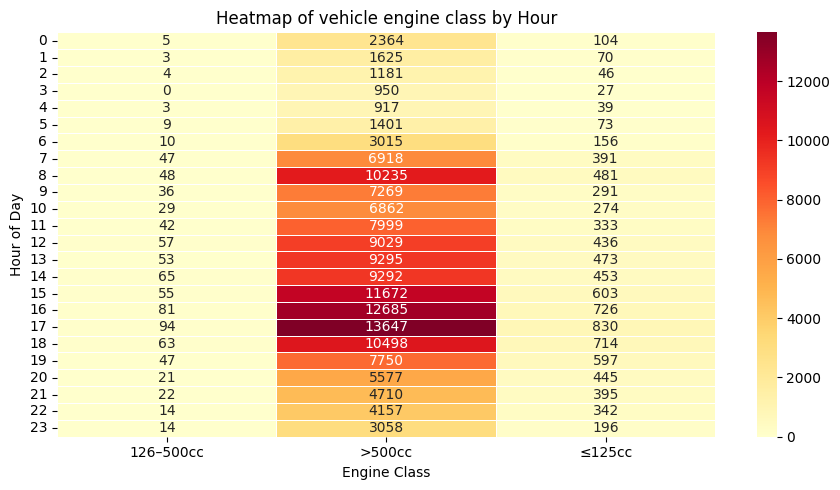

In [241]:
# Create pivot table
pivot = unique_vehicle_data2019.pivot_table(
    index='hour',
    columns='engine_class',
    aggfunc='size',
    fill_value=0
)

# Plot heatmap
plt.figure(figsize=(9, 5))
sns.heatmap(pivot, cmap='YlOrRd', linewidths=.5, annot=True, fmt='d')
plt.title('Heatmap of vehicle engine class by Hour')
plt.ylabel('Hour of Day')
plt.xlabel('Engine Class')
plt.tight_layout()
plt.show()

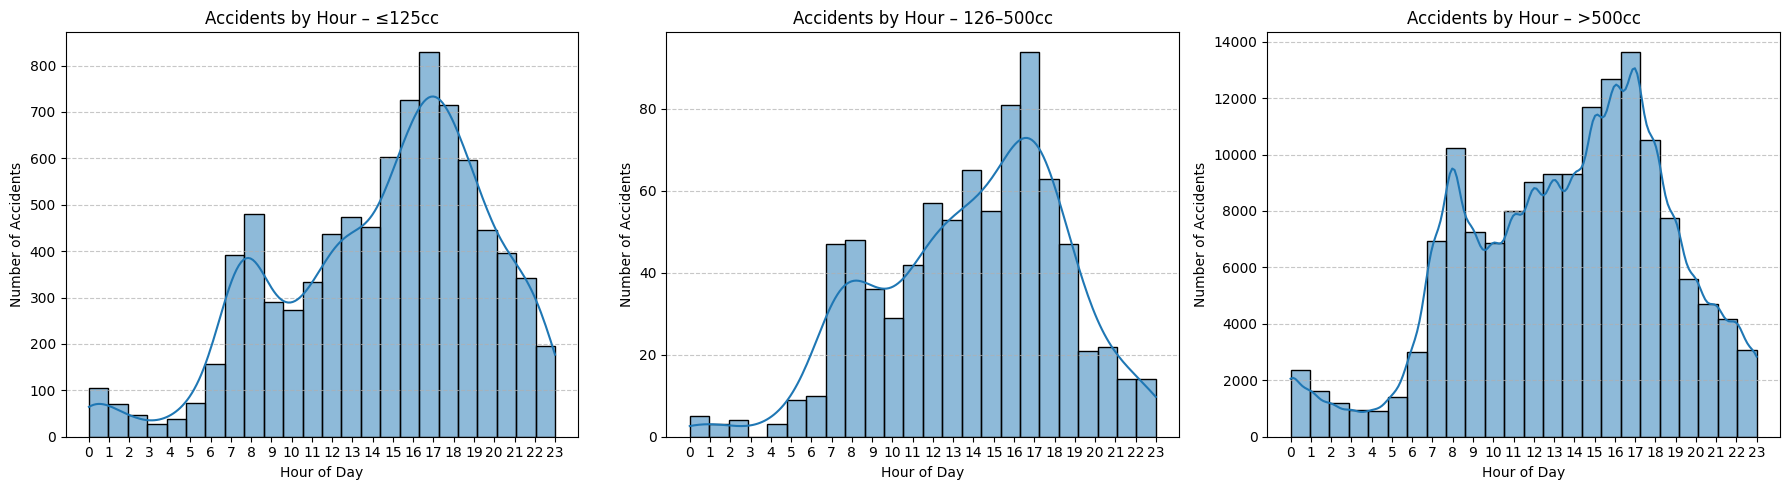

In [513]:
# Unique engine classes
engine_classes = ['≤125cc', '126–500cc', '>500cc']

# Create a  subplot for hour of day for engine classes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ecc in enumerate(engine_classes): # Create loop to assign each class to a subplot
    subset = unique_vehicle_data2019[unique_vehicle_data2019['engine_class'] == ecc]
    sns.histplot(subset['hour'], bins=24, edgecolor='black', ax=axes[i],kde=True) # Create plot for hours of day
    axes[i].set_title(f'Accidents by Hour – {ecc}')
    axes[i].set_xlabel('Hour of Day')
    axes[i].set_ylabel('Number of Accidents')
    axes[i].set_xticks(range(0, 24))
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show() # Display plots

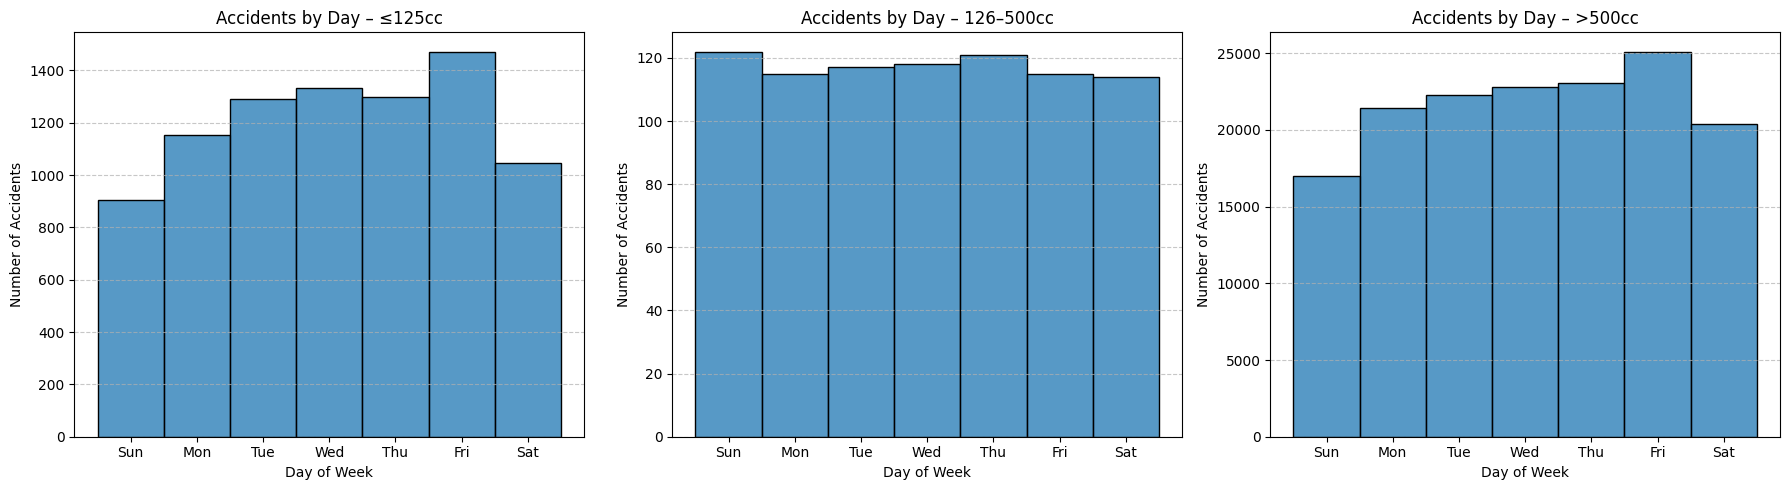

In [512]:
# map day names for labels
day_labels = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

# Subplot for day of week
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, ecc in enumerate(engine_classes): # Create loop to assign each class to a subplot
    subset = unique_vehicle_data2019[unique_vehicle_data2019['engine_class'] == ecc]
    sns.histplot(subset['day_of_week'], bins=7, discrete=True, edgecolor='black', ax=axes[i]) # Create plot for days of week
    axes[i].set_title(f'Accidents by Day – {ecc}')
    axes[i].set_xlabel('Day of Week')
    axes[i].set_ylabel('Number of Accidents')
    axes[i].set_xticks(range(1, 8))
    axes[i].set_xticklabels(day_labels)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


#### E3
Are there any particular hours of the day, and days of the week, on which pedestrian are more likely 
to be involved in an accidents to a significant degree?

In [60]:
# Eliminate Redundancy Create by Many-Many-joining to obtain unique casualty columns and assign dataframe to a new variable
unique_casualty_data2019 = acc_data2019.groupby(['accident_index', 'vehicle_reference', 'casualty_reference']).first().reset_index()

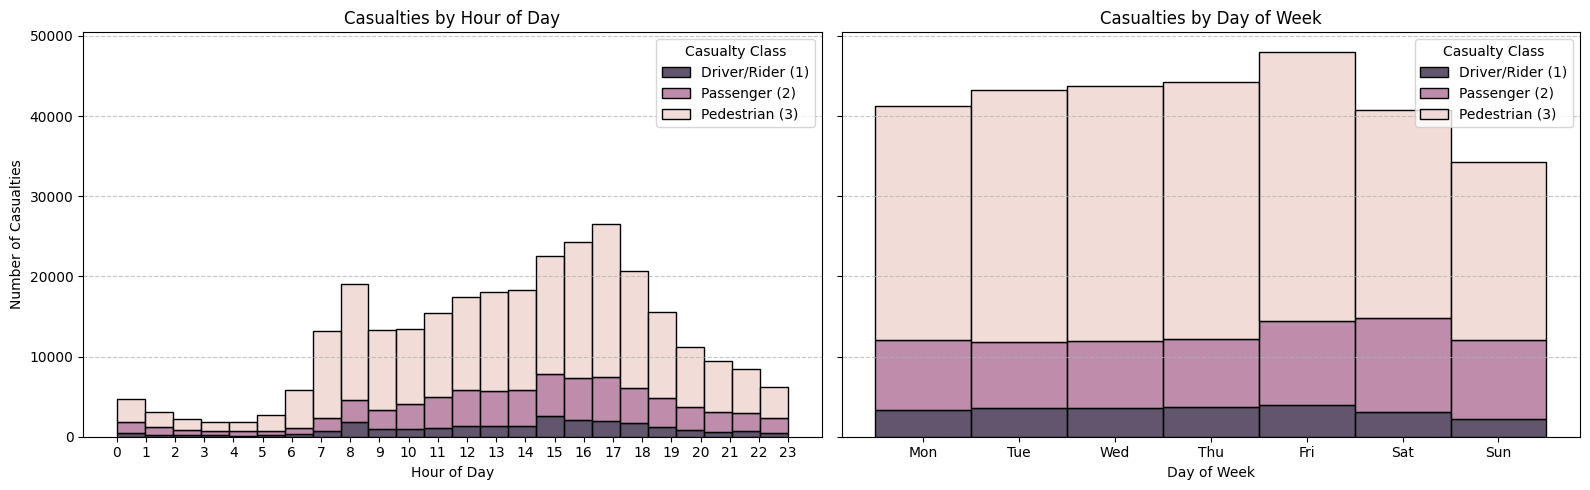

In [61]:
# map day numbers to names
day_map = {1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed', 5: 'Thu', 6: 'Fri', 7: 'Sat'}
unique_casualty_data2019['day_of_week'] = unique_casualty_data2019['day_of_week'].map(day_map)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# plot histogram of casualties by Hour
sns.histplot(data=unique_casualty_data2019, x='hour',hue='casualty_class', multiple='stack',
             bins=24, edgecolor='black', ax=axes[0]
            )
axes[0].set_title('Casualties by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Number of Casualties')
axes[0].set_xticks(range(0, 24))
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
axes[0].legend(title='Casualty Class', labels=['Driver/Rider (1)', 'Passenger (2)', 'Pedestrian (3)'])

# plot histogram of casualties by Days of week
sns.histplot(
    data=unique_casualty_data2019, x='day_of_week',
    hue='casualty_class', multiple='stack',
    discrete=True, edgecolor='black', ax=axes[1]
   )
axes[1].set_title('Casualties by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Legend and layout
axes[1].legend(title='Casualty Class', labels=['Driver/Rider (1)', 'Passenger (2)', 'Pedestrian (3)'])
plt.tight_layout()
plt.show() # Display plot


#### E4
explore the impact of selected variables on the accident severity using the apriori algorithm and association rule

In [425]:
# Select variables of interest for Association Rule Minnig
selected_cols = [
    'accident_severity',
    'light_conditions',
    'weather_conditions',
    'road_surface_conditions',
    'urban_or_rural_area',
    'speed_limit',
    'hour',
   'road_type',
    'junction_detail'
]
# copy selected columns to a new daatframe
# Ensure all missing values are converted to NaN
apriori_data = unique_acc2019_indexes[selected_cols].copy()
apriori_data['weather_conditions'].replace(9,np.nan, inplace=True)
apriori_data['light_conditions'].replace(7,np.nan, inplace=True)
apriori_data['road_type'].replace(9,np.nan, inplace=True)
apriori_data.dropna(inplace=True) # Drop NaN

In [426]:
# Mapping dictionaries, to convert code ID to its meaningful string
severity_map = {
    1: 'Fatal',
    2: 'Serious',
    3: 'Slight'
}

light_map = {
    1: 'Daylight',
    4: 'Darkness - lights lit',
    5: 'Darkness - lights unlit',
    6: 'Darkness - no lighting',
}

weather_map = {
    1: 'Fine without high winds',
    2: 'Raining without high winds',
    3: 'Snowing without high winds',
    4: 'Fine with high winds',
    5: 'Raining with high winds',
    6: 'Snowing with high winds',
    7: 'Fog or mist',
    8: 'Other',
}

road_surface_map = {
    1: 'Dry',
    2: 'Wet or damp',
    3: 'Snow',
    4: 'Frost or ice',
    5: 'Flood'
}

urban_rural_map = {
    1: 'Urban',
    2: 'Rural',
}

road_type_map = {
    1: 'Roundabout',
    2: 'One way street',
    3: 'Dual carriageway',
    6: 'Single carriageway',
    7: 'Slip road'
}

junction_detail_map = {
    0: 'Not at junction',
    1: 'Roundabout',
    2: 'Mini-roundabout',
    3: 'T-junction',
    5: 'Slip road',
    6: 'Crossroads',
    7: 'More than 4 arms (not roundabout)',
    8: 'Private drive or entrance',
    9: 'Other junction'
}


# Apply mappings to DataFrame
apriori_data['accident_severity'] = apriori_data['accident_severity'].map(severity_map)
apriori_data['light_conditions'] = apriori_data['light_conditions'].map(light_map)
apriori_data['weather_conditions'] = apriori_data['weather_conditions'].map(weather_map)
apriori_data['road_surface_conditions'] = apriori_data['road_surface_conditions'].map(road_surface_map)
apriori_data['urban_or_rural_area'] = apriori_data['urban_or_rural_area'].map(urban_rural_map)
apriori_data['speed_limit'] = apriori_data['speed_limit'].astype(str)
apriori_data['hour'] = apriori_data['hour'].astype(str)
apriori_data['junction_detail'] = apriori_data['junction_detail'].map(junction_detail_map)
apriori_data['road_type'] = apriori_data['road_type'].map(road_type_map)

In [427]:
# Apply OneHotEncoder to create dummy variables
encoder = OneHotEncoder(sparse=False)
encoded_array = encoder.fit_transform(apriori_data)

# Convert back to DataFrame
df_encoded = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(apriori_data.columns))

# Convert to bool
df_encoded = df_encoded.astype(bool)

In [442]:
# Find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.2, use_colnames=True)

# Add length column (number of items in the itemset)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))

# Generate rules with accident severity as the consequence
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

Filter association where accident severity appears as consequent

In [443]:
# Define severity labels
severity_labels = ['accident_severity_Fatal','accident_severity_Serious','accident_severity_Slight']

# Filter rules with only one item in the consequent and that item is in severity_labels
rules_filtered = rules[
    (rules['consequents'].apply(lambda x: len(x) == 1)) &
    (rules['consequents'].apply(lambda x: list(x)[0] in severity_labels))
]
# Sort by lift
rules_filtered = rules_filtered.sort_values(by='lift', ascending=False)

# Display consequent
rules_filtered[['antecedents','consequents','support','confidence','lift','leverage','conviction']].head(100)

antecedents  \
77                                                                                                           (urban_or_rural_area_Urban, light_conditions_Daylight)   
345                                                                             (urban_or_rural_area_Urban, road_surface_conditions_Dry, light_conditions_Daylight)   
693                                 (urban_or_rural_area_Urban, road_surface_conditions_Dry, light_conditions_Daylight, weather_conditions_Fine without high winds)   
811                                                           (speed_limit_30.0, urban_or_rural_area_Urban, road_surface_conditions_Dry, light_conditions_Daylight)   
372                                                                                        (speed_limit_30.0, urban_or_rural_area_Urban, light_conditions_Daylight)   
1109              (urban_or_rural_area_Urban, road_surface_conditions_Dry, light_conditions_Daylight, weather_conditions_Fine without high winds, speed_limit_30.0)   
315                                                              (urban_or_rural_area_Urban, light_conditions_Daylight, weather_conditions_Fine without high winds)   
755                                            (speed_limit_30.0, urban_or_rural_area_Urban, light_conditions_Daylight, weather_conditions_Fine without high winds)   
355                                                                                      (speed_limit_30.0, road_surface_conditions_Dry, light_conditions_Daylight)   
83                                                                                                                    (speed_limit_30.0, light_conditions_Daylight)   
829                                               (urban_or_rural_area_Urban, road_surface_conditions_Dry, light_conditions_Daylight, road_type_Single carriageway)   
715                                          (speed_limit_30.0, road_surface_conditions_Dry, light_conditions_Daylight, weather_conditions_Fine without high winds)   
383                                                                            (urban_or_rural_area_Urban, light_conditions_Daylight, road_type_Single carriageway)   
1148  (urban_or_rural_area_Urban, road_surface_conditions_Dry, road_type_Single carriageway, light_conditions_Daylight, weather_conditions_Fine without high winds)   
861                                                          (speed_limit_30.0, urban_or_rural_area_Urban, light_conditions_Daylight, road_type_Single carriageway)   
326                                                                       (speed_limit_30.0, light_conditions_Daylight, weather_conditions_Fine without high winds)   
121                                                                                                        (urban_or_rural_area_Urban, road_surface_conditions_Dry)   
475                                                                                      (speed_limit_30.0, urban_or_rural_area_Urban, road_surface_conditions_Dry)   
401                                                            (urban_or_rural_area_Urban, road_surface_conditions_Dry, weather_conditions_Fine without high winds)   
775                                (urban_or_rural_area_Urban, light_conditions_Daylight, road_type_Single carriageway, weather_conditions_Fine without high winds)   
1218             (urban_or_rural_area_Urban, light_conditions_Daylight, road_type_Single carriageway, weather_conditions_Fine without high winds, speed_limit_30.0)   
880                                          (speed_limit_30.0, urban_or_rural_area_Urban, road_surface_conditions_Dry, weather_conditions_Fine without high winds)   
844                                                        (speed_limit_30.0, road_surface_conditions_Dry, light_conditions_Daylight, road_type_Single carriageway)   
393                                                                                     (speed_limit_30.0, road_type_Single carriageway, light_c

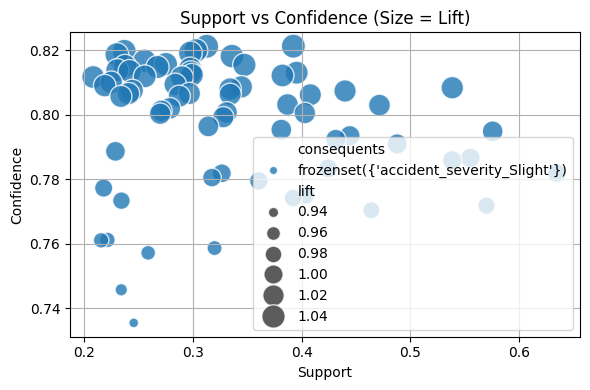

In [444]:
# Scatter Plot for Support vs Confidence
plt.figure(figsize=(6, 4))
sns.scatterplot(data=rules_filtered, x='support', y='confidence', size='lift', hue='consequents', sizes=(50, 300), alpha=0.8)
plt.title('Support vs Confidence (Size = Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.grid(True)
plt.tight_layout()
plt.show()

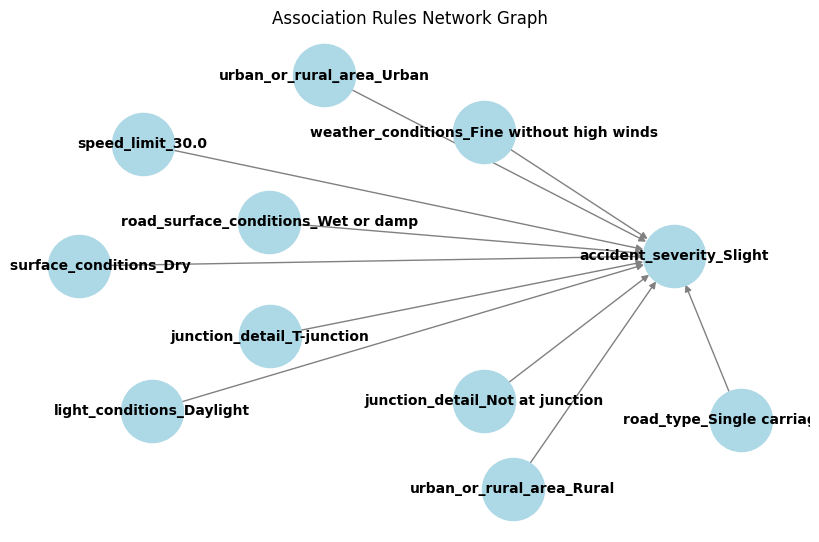

'\nThis code creates a directed graph to visualize the relationships from an association rule mining analysis. It represents the rules as a \nnetwork where the factors (antecedents and consequents) are the nodes, and the "if-then" relationships are the directed edges.\n'

In [510]:
# Create directed graph
G = nx.DiGraph()

# Add edges from rules DataFrame
for _, row in rules_filtered.iterrows():
    for ant in row['antecedents']:
        for con in row['consequents']:
            G.add_edge(ant, con, weight=row['lift'])

# Draw
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue',
        font_size=10, font_weight='bold', edge_color='gray')
plt.title("Association Rules Network Graph")
plt.show()
'''
This code creates a directed graph to visualize the relationships from an association rule mining analysis. It represents the rules as a 
network where the factors (antecedents and consequents) are the nodes, and the "if-then" relationships are the directed edges.
'''

#### E5
Run clustering algorithm methods on regions including Kingston upon Hull, Humberside, and the East Riding of 
Yorkshire to see what clustering reveals about the distribution of the accidents across our region?

In [362]:
# Filter Humberside police area 
Humberside_police_area= unique_acc2019_indexes[unique_acc2019_indexes['police_force']==16]

# filter latitude,longitude& Speed
geo_data = Humberside_police_area[[
        'longitude','latitude','speed_limit'
]].dropna()

In [514]:
# Fit DBSCAN
db = DBSCAN(eps=0.3, min_samples=10)
geo_data['cluster'] = db.fit_predict(geo_data)

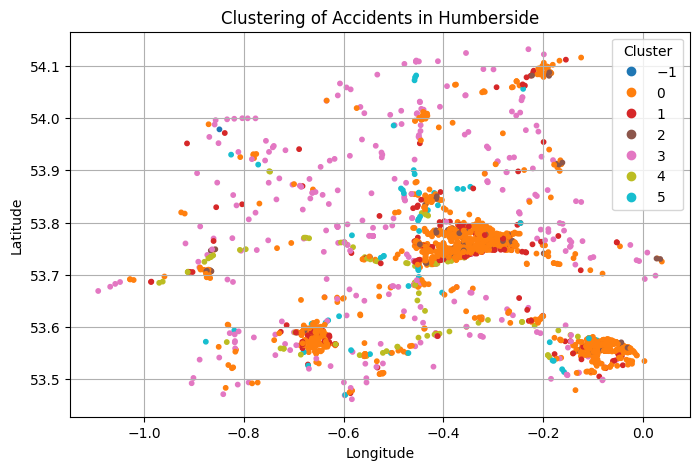

In [515]:
# PLot scattered plot and apply cluster
plt.figure(figsize=(8,5))
scatter = plt.scatter(geo_data['longitude'], geo_data['latitude'], 
                      c=geo_data['cluster'], cmap='tab10', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Accidents in Humberside')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [366]:
# Initialize base map
m = folium.Map(location=[geo_data['latitude'].mean(), geo_data['longitude'].mean()], zoom_start=11)

# Normalize color map for unique clusters
unique_clusters = geo_data['cluster'].unique()
colormap = cm.get_cmap('tab20', len(unique_clusters))
norm = colors.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))

# Plot each point with color-coded cluster
for _, row in geo_data.iterrows():
    cluster = row['cluster']
    color = colors.to_hex(colormap(norm(cluster)))

    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {cluster}"
    ).add_to(m)

# Show map
m

C:\Users\Rotim\AppData\Local\Temp\ipykernel_24488\4072825520.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', len(unique_clusters))


In [369]:
# Metrics evaluation
silhouette = silhouette_score(geo_data[['longitude','latitude','speed_limit']], geo_data['cluster'])
davies_bouldin = davies_bouldin_score(geo_data[['longitude','latitude','speed_limit']], geo_data['cluster'])

# Print metrics
print("Silhouette Score:", silhouette)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.9551388955734801
Davies-Bouldin Index: 0.1577636012386476


Apply K-mean clustering

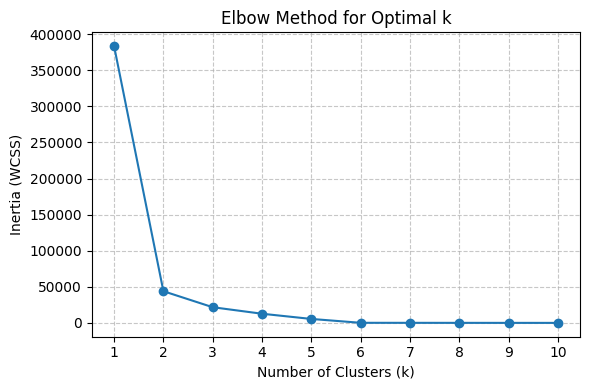

In [374]:
# Calculate inertia for k between 1 to 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(geo_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.xticks(K_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [375]:
# Perform Kmean clustering
kmeans = KMeans(n_clusters=2, random_state=42)
geo_data['kmean_cluster'] = kmeans.fit_predict(geo_data)

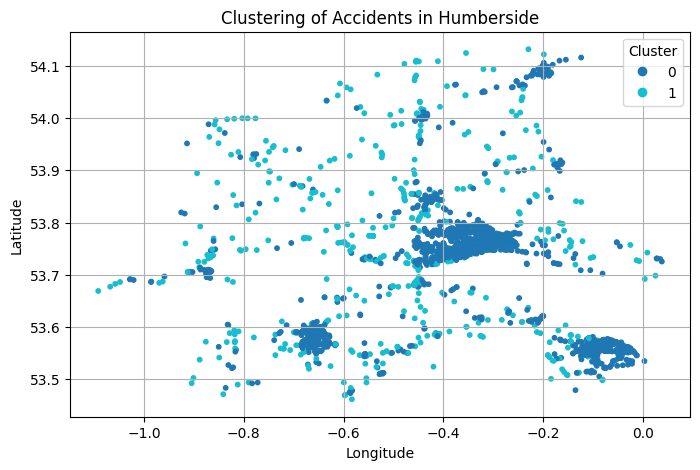

In [383]:
# PLot scattered plot and apply cluster
plt.figure(figsize=(8,5))
scatter = plt.scatter(geo_data['longitude'], geo_data['latitude'], 
                      c=geo_data['kmean_cluster'], cmap='tab10', s=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustering of Accidents in Humberside')
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

In [384]:
#  metrics calculation
silhouette = silhouette_score(geo_data[['longitude','latitude','speed_limit']], geo_data['kmean_cluster'])
davies_bouldin = davies_bouldin_score(geo_data[['longitude','latitude','speed_limit']], geo_data['kmean_cluster'])
calinski_harabasz = calinski_harabasz_score(geo_data[['longitude','latitude','speed_limit']],geo_data['kmean_cluster'])
# Print metrics
print("Silhouette Score:", silhouette) 
print("Davies-Bouldin Index:", davies_bouldin)
print("Calinski-Harabasz Index:", calinski_harabasz)

Silhouette Score: 0.8718750672811829
Davies-Bouldin Index: 0.19144142793597935
Calinski-Harabasz Index: 17927.343668969963


#### E6

Choose three policing areas and create a time series model for each area predicting weekly accident counts for 
2019 based on historical data from 2017 to 2018. Assess how these predictions compare for each 
of the chosen policing areas with the actual 2019 accident data

##### Preprocess dataset

In [81]:
# Filter unique accident reference to eliminate redundancy from many to many joining
unique_accdata =acc_data.groupby('accident_index').first()

# Fetch desired police area form main dataset
police_area = unique_accdata[unique_accdata['police_force'].isin([13, 14, 16])] # 13 west, 14 south & 16- East yorkshire

In [82]:
# Group Accident by week and police force Area
weekly_counts = police_area.groupby([
    'police_force',
    pd.Grouper(key='date', freq='W')
]).size().reset_index(name='accident_count')

# Show count
weekly_counts.set_index('date', inplace=True)

In [83]:
def split_train_test_by_force(data, police_force, train_years, test_year):
    """
    Splits weekly time series data into train and test sets by police force and year.

    Returns:
        train (DataFrame): Filtered training data.
        test (DataFrame): Filtered test data.
    """
    train = data[
        (data['police_force'] == police_force) &
        (data.index.year.isin(train_years))
    ]

    test = data[
        (data['police_force'] == police_force) &
        (data.index.year == test_year)
    ]

    return train, test

Extract accident in East, West and South Yorkshire each into separate dataframe

In [84]:
# For West Yorkshire (13)
train_wy, test_wy = split_train_test_by_force(weekly_counts, police_force=13, train_years=[2017, 2018], test_year=2019)

# For South Yorkshire (14)
train_sy, test_sy = split_train_test_by_force(weekly_counts, police_force=14, train_years=[2017, 2018], test_year=2019)

# For East Yorkshire (16)
train_ey, test_ey = split_train_test_by_force(weekly_counts, police_force=16, train_years=[2017, 2018], test_year=2019)

##### TIME SERIES Police_Area-Exploratory Analysis

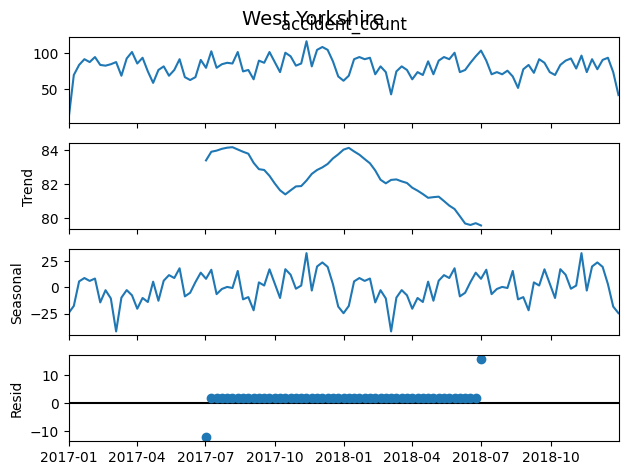

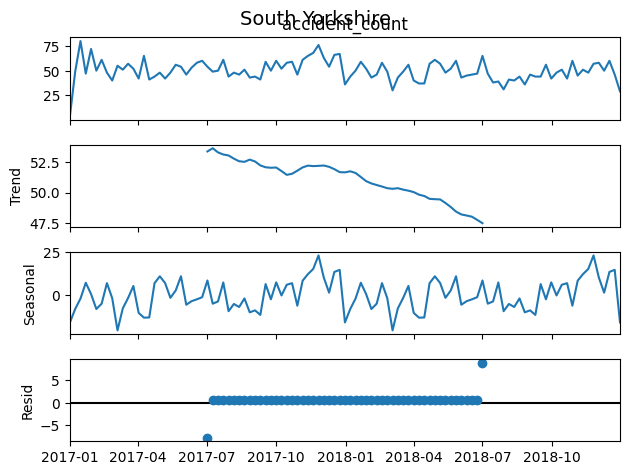

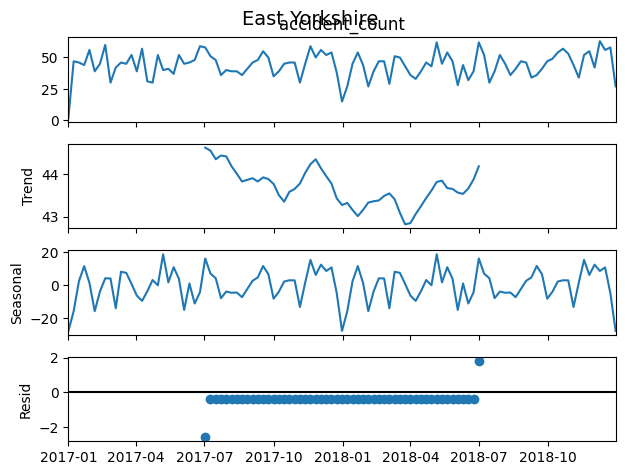

In [85]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Perform decomposition
res_wy = seasonal_decompose(train_wy['accident_count'], period=52)
res_sy = seasonal_decompose(train_sy['accident_count'], period=52)
res_ey = seasonal_decompose(train_ey['accident_count'], period=52)

res_wy.plot()
plt.suptitle('West Yorkshire', fontsize=14)
plt.show()

res_sy.plot()
plt.suptitle('South Yorkshire', fontsize=14)
plt.show()

res_ey.plot()
plt.suptitle('East Yorkshire', fontsize=14)
plt.show()

INVESTIGATION OF TIME SERIES PROCESS

In [88]:
def run_adf_test(series, name=''):
    """
    Runs the Augmented Dickey-Fuller test on a time series.
    Prints:
        ADF statistic, p-value, and critical values.
    """
    result = adfuller(series)  # dropna to avoid errors

    print(f'ADF Test Results for: {name if name else "Unnamed Series"}')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('\n')


# Run ADF test on West Yorkshire training data
run_adf_test(train_wy['accident_count'], name='West Yorkshire (Train)')

# Run on South Yorkshire if you have it
run_adf_test(train_sy['accident_count'], name='South Yorkshire (Train)')

# Run on South Yorkshire if you have it
run_adf_test(train_ey['accident_count'], name='East Yorkshire (Train)')

ADF Test Results for: West Yorkshire (Train)
ADF Statistic: -8.390005880909992
p-value: 2.3807580292835854e-13


ADF Test Results for: South Yorkshire (Train)
ADF Statistic: -8.86846276069913
p-value: 1.4191786352594175e-14


ADF Test Results for: East Yorkshire (Train)
ADF Statistic: -4.771808785418226
p-value: 6.155735945958514e-05




##### WEST YOKSHIRE AREA PREDICTION

In [127]:
# Create function to find the best AIC for the model
# Define SARIMA search figures
ps = np.arange(0, 13, 1)  # AR orders
qs = np.arange(0, 13, 1)  # MA orders
Ps = [0,1]                 # Seasonal AR
Qs = [0,1]                 # Seasonal MA
d = 0                    # Differencing order
D = 1                    # Seasonal differencing
s = 52                   # Seasonal period

# Create all (p, q, Ps, Qs) combinations
p_q_list = list(product(ps, qs, Ps, Qs))


#  Define AIC evaluation function
def aic_values(target_series):
    """
    Runs SARIMA models over all (p, q, P=0, Q=0) pairs and returns AIC values.
    
    Parameters:
        target_series (pd.Series): Time series to model (must have DatetimeIndex)
    
    Returns:
        pd.DataFrame: Sorted DataFrame of model orders and AIC values
    """
    results = []
    for order in tqdm(p_q_list):
        try:
            model = SARIMAX(
                endog=target_series,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            results.append([order, model.aic])
        except:
            continue
    return pd.DataFrame(results, columns=['Order(p,q,Ps,Qs)', 'AIC']).sort_values('AIC')


# Run AIC search on train_wy
# Ensure train_wy is indexed by datetime and has 'accident_count' column
aic_df_wy = aic_values(train_wy['accident_count'])

# Display best models
print(aic_df_wy.head())


100%|██████████████████████████████████████████████████████████████████████████████| 676/676 [1:23:58<00:00,  7.45s/it]

   Order(p,q,Ps,Qs)        AIC
14     (0, 3, 1, 0) -13.712159
2      (0, 0, 1, 0) -10.637306
6      (0, 1, 1, 0)  -9.452642
10     (0, 2, 1, 0)  -5.443183
18     (0, 4, 1, 0)  -2.892571


In [89]:
# Fit the best SARIMA model for West Yorkshire
result_wy = SARIMAX(
    train_wy['accident_count'],
    order=(0, 0, 3),
    seasonal_order=(1, 1, 0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the same length as the test set (2019 weeks)
forecast = result_wy.get_forecast(steps=len(test_wy))
pred = forecast.predicted_mean


# Add predicted values and error
test_wy.loc[:, 'forecast'] = pred.values.round()
test_wy.loc[:, 'Error'] = test_wy['accident_count'] - test_wy['forecast']
test_wy.loc[:, 'Abs_error'] = abs(test_wy.loc[:, 'Error'])

# View result
test_wy.head()


C:\Users\Rotim\AppData\Local\Temp\ipykernel_24488\3840844190.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_wy.loc[:, 'forecast'] = pred.values.round()
C:\Users\Rotim\AppData\Local\Temp\ipykernel_24488\3840844190.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_wy.loc[:, 'Error'] = test_wy['accident_count'] - test_wy['forecast']
C:\Users\Rotim\AppData\Local\Temp\ipykernel_24488\3840844190.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

police_force  accident_count  forecast  Error  Abs_error
date                                                                
2019-01-06            13              39      68.0  -29.0       29.0
2019-01-13            13              60      88.0  -28.0       28.0
2019-01-20            13              75      93.0  -18.0       18.0
2019-01-27            13              88      90.0   -2.0        2.0
2019-02-03            13              60      93.0  -33.0       33.0

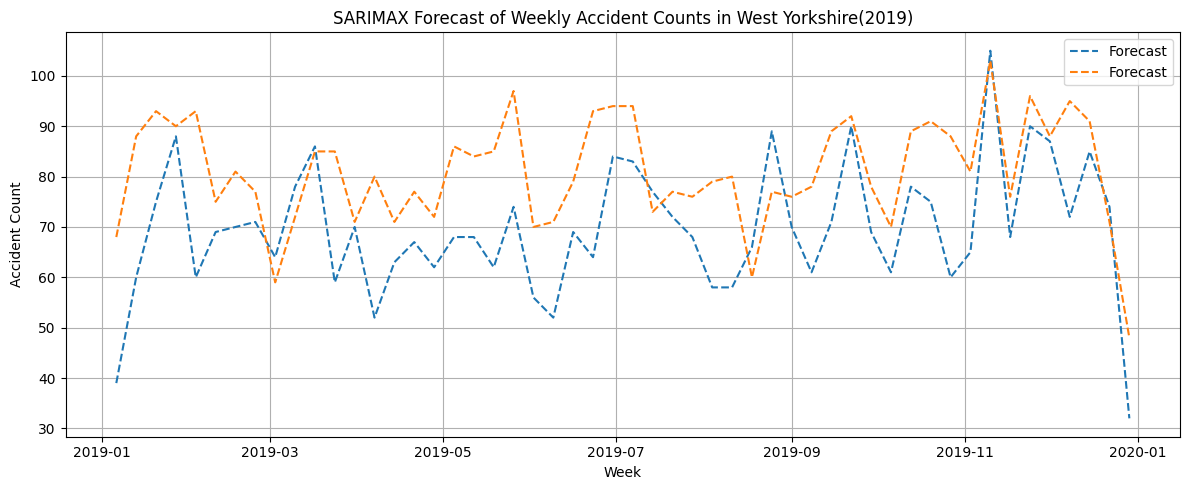

In [504]:
# Plot actual  forecast
plt.figure(figsize=(12, 5))
#plt.plot(train_wy['accident_count'], label='Observed')
plt.plot( test_wy['accident_count'], label='Forecast', linestyle='--')
plt.plot( test_wy['forecast'], label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast of Weekly Accident Counts in West Yorkshire(2019)')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Squared Error (MSE):  245.31
Mean Absolute Error (MAE): 13.00


Text(0.5, 1.0, 'ERROR DISTRIBUTION IN FORECAST')

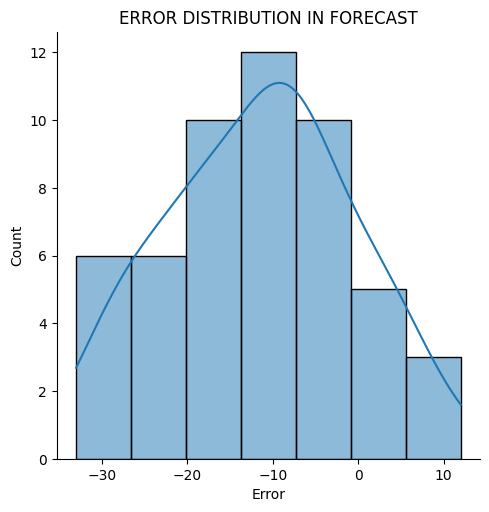

In [91]:
# MSE & MAE
mse = mean_squared_error(test_wy['accident_count'], test_wy['forecast'])
mae = mean_absolute_error(test_wy['accident_count'], test_wy['forecast'])

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# residual plot
sns.displot(test_wy['Error'],kde=True)
plt.title('ERROR DISTRIBUTION IN FORECAST')

##### SOUTH YORKSHIRE

In [128]:
# Run AIC search on south yorkshire data
# Recall the defined function from above
aic_df_sy = aic_values(train_sy['accident_count'])

# Display best models
print(aic_df_sy.head())


100%|██████████████████████████████████████████████████████████████████████████████| 676/676 [1:10:11<00:00,  6.23s/it]

   Order(p,q,Ps,Qs)        AIC
2      (0, 0, 1, 0) -11.855053
6      (0, 1, 1, 0) -10.460891
10     (0, 2, 1, 0)  -9.092604
14     (0, 3, 1, 0)  -7.336586
18     (0, 4, 1, 0)  -3.210178


In [508]:
# Fit the best SARIMA model for West Yorkshire
result_sy = SARIMAX(
    train_sy['accident_count'],
    order=(1, 0, 3),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the same length as the test set
forecast = result_sy.get_forecast(steps=len(test_sy))
pred = forecast.predicted_mean


# Add predicted values and error
test_sy.loc[:, 'forecast'] = pred.values.round()
test_sy.loc[:, 'Error'] = test_sy['accident_count'] - test_sy['forecast']
test_sy.loc[:, 'Abs_error'] = abs(test_sy.loc[:, 'Error'])


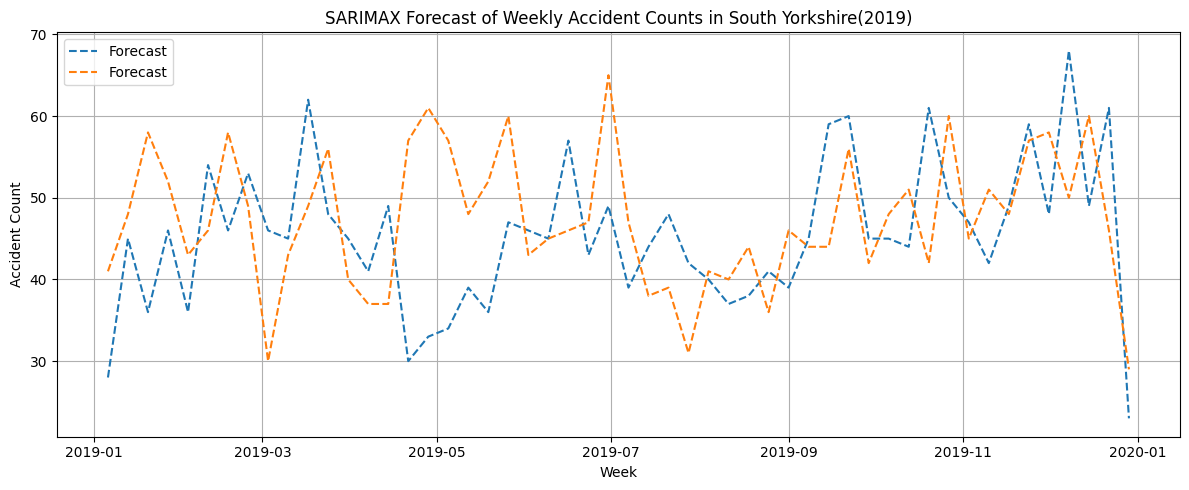

In [503]:
# Plot actual forecast
plt.figure(figsize=(12, 5))
#plt.plot(train_sy['accident_count'], label='Observed')
plt.plot( test_sy['accident_count'], label='Forecast', linestyle='--')
plt.plot( test_sy['forecast'], label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast of Weekly Accident Counts in South Yorkshire(2019)')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Squared Error (MSE):  128.60
Mean Absolute Error (MAE): 9.17


Text(0.5, 1.0, 'ERROR DISTRIBUTION IN FORECAST')

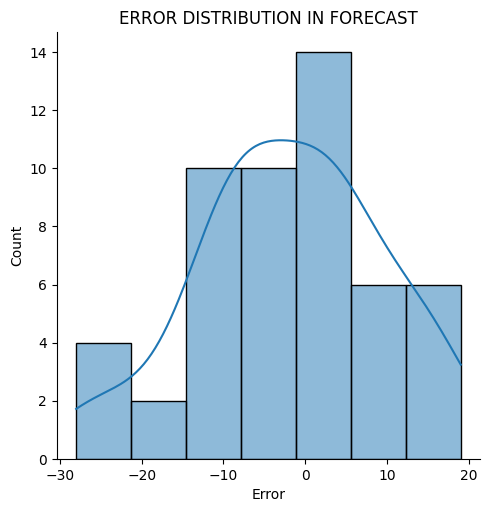

In [107]:
# MSE & MAE
mse = mean_squared_error(test_sy['accident_count'], test_sy['forecast'])
mae = mean_absolute_error(test_sy['accident_count'], test_sy['forecast'])

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


# residual plot
sns.displot(test_sy['Error'],kde=True)
plt.title('ERROR DISTRIBUTION IN FORECAST')

##### EAST YORKSHIRE

In [129]:
# Run AIC search on East Yorkshire data
# Recall the defined AIC function from above
aic_df_ey = aic_values(train_ey['accident_count'])

# Display best models
print(aic_df_ey.head())

100%|██████████████████████████████████████████████████████████████████████████████| 676/676 [1:14:04<00:00,  6.57s/it]

   Order(p,q,Ps,Qs)        AIC
2      (0, 0, 1, 0) -13.212438
6      (0, 1, 1, 0) -12.181630
10     (0, 2, 1, 0)  -8.856302
22     (0, 5, 1, 0)  -7.695682
14     (0, 3, 1, 0)  -7.657558


In [505]:
# Fit the best SARIMA model for West Yorkshire
result_ey = SARIMAX(
    train_ey['accident_count'],
    order=(0, 0, 3),
    seasonal_order=(1, 1, 1, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Forecast for the same length as the test set (2019 weeks)
forecast = result_ey.get_forecast(steps=len(test_ey))
pred = forecast.predicted_mean


# Add predicted values and error
test_ey.loc[:, 'forecast'] = pred.values.round()
test_ey.loc[:, 'Error'] = test_ey['accident_count'] - test_ey['forecast']
test_ey.loc[:, 'Abs_error'] = abs(test_ey.loc[:, 'Error'])


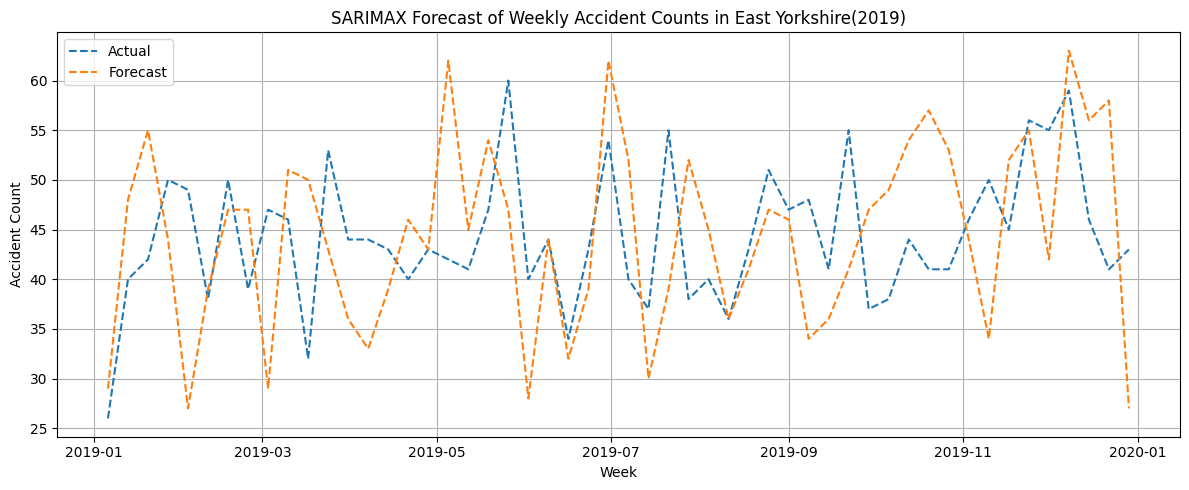

In [506]:
# Plot actual  forecast
plt.figure(figsize=(12, 5))
#plt.plot(train_ey['accident_count'], label='Observed')
plt.plot( test_ey['accident_count'], label='Actual', linestyle='--')
plt.plot( test_ey['forecast'], label='Forecast', linestyle='--')
plt.title('SARIMAX Forecast of Weekly Accident Counts in East Yorkshire(2019)')
plt.xlabel('Week')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Mean Squared Error (MSE):  109.17
Mean Absolute Error (MAE): 8.71


Text(0.5, 1.0, 'ERROR DISTRIBUTION IN FORECAST')

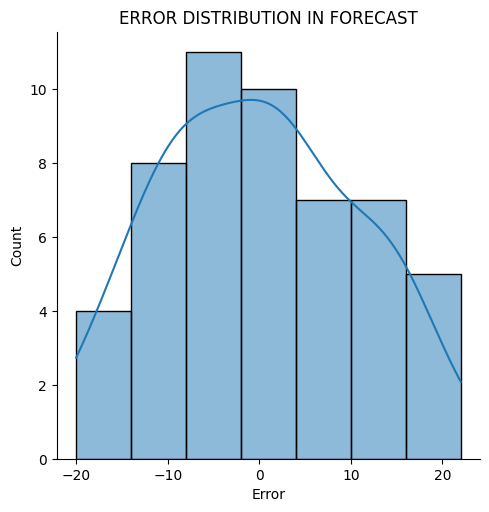

In [111]:
# MSE & MAE
mse = mean_squared_error(test_ey['accident_count'], test_ey['forecast'])
mae = mean_absolute_error(test_ey['accident_count'], test_ey['forecast'])

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


# residual plot
sns.displot(test_ey['Error'],kde=True)
plt.title('ERROR DISTRIBUTION IN FORECAST')

Identify the top thirty (30) Local Super Output Areas (LSOAs) for the City of Hull that recorded 
the highest number of road accidents in the first three months of 2019. Then aggregate these 
top thirty records together, so you can employ a time series model leveraging data for the first 
six months of 2019 (e.g., January to June) for these high incident areas so you can forecast the 
daily accident occurrences for the following month (e.g., July).  

##### Preprocessing

In [112]:
# Filter for Hull and Jan–Mar 2019
hull_city = unique_acc2019_indexes['lsoa01nm'].str.contains('kingston upon hull', case=False, na=False)
first_quarter_2019 = (unique_acc2019_indexes['date'] >= '2019-01-01') & (unique_acc2019_indexes['date'] < '2019-04-01')

hull_q1_2019 = unique_acc2019_indexes[hull_city & first_quarter_2019]



# Identify Top 30 LSOAs by Count
top_lsoas = (
    hull_q1_2019['lsoa01nm']
    .value_counts()
    .head(30)
    .index.tolist()
)

# Extract Jan–June 2019 Data for Top 30 LSOAs
jan_to_june = (unique_acc2019_indexes['date'] >= '2019-01-01') & (unique_acc2019_indexes['date'] < '2019-08-01')
top_lsoa_data = unique_acc2019_indexes[hull_city & unique_acc2019_indexes['lsoa01nm'].isin(top_lsoas) & jan_to_june]

# Convert and normalize dates (drop time)
top_lsoa_data['date'] = top_lsoa_data['date'].dt.normalize()

# Aggregate Daily Accident Counts
daily_counts = (
    top_lsoa_data
    .groupby('date')
    .size()
    .asfreq('D', fill_value=0)
    .reset_index(name='accident_count')
)


# Set date as index
daily_counts.set_index('date', inplace=True)

train = daily_counts[(daily_counts.index >= '2019-01-01') & (daily_counts.index < '2019-07-01')]
test = daily_counts[(daily_counts.index >= '2019-07-01') & (daily_counts.index < '2019-08-01')]

C:\Users\Rotim\AppData\Local\Temp\ipykernel_24488\265057166.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_lsoa_data['date'] = top_lsoa_data['date'].dt.normalize()


##### Exploratory check

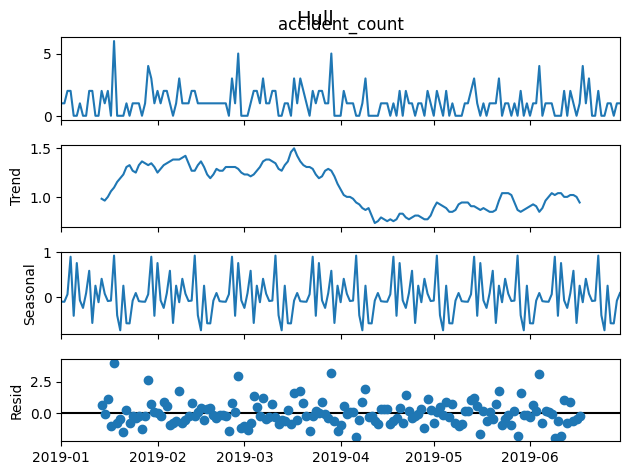

In [113]:
# Perform decomposition
res_hull = seasonal_decompose(train['accident_count'], period=26)

res_hull.plot()
plt.suptitle('Hull', fontsize=14)
plt.show()

In [114]:
# Recall ADF function defined in question 6
# Run ADF test on Hull data to assess stationarity in daily accident count
run_adf_test(train['accident_count'], name='Hull')

ADF Test Results for: Hull
ADF Statistic: -14.453544888857623
p-value: 7.033969379978086e-27




In [495]:
# Define SARIMA Params
ps = np.arange(0, 4, 1)
qs = np.arange(0, 4, 1)
Ps = [0]
Qs = [0]
d = 0
D = 1
s = 30  # weekly seasonality 

p_q_list = list(product(ps, qs, Ps, Qs))

# define AIC Evaluation Function
def aic_values(target_series):
    results = []
    for order in tqdm(p_q_list):
        try:
            model = SARIMAX(
                endog=target_series,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            results.append([order, model.aic])
        except:
            continue
    return pd.DataFrame(results, columns=['Order(p,q,Ps,Qs)', 'AIC']).sort_values('AIC')


# Run AIC Search
aic_df = aic_values(train['accident_count'])
best_order = aic_df.iloc[0]['Order(p,q,Ps,Qs)']
p, q, P, Q = best_order

aic_df.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:12<00:00,  1.33it/s]


Order(p,q,Ps,Qs)         AIC
15     (3, 3, 0, 0)  524.562251
10     (2, 2, 0, 0)  526.300124
3      (0, 3, 0, 0)  527.540115
2      (0, 2, 0, 0)  528.073695
7      (1, 3, 0, 0)  529.219748

In [496]:
# Fit Best Model & Forecast
model = SARIMAX(
    train['accident_count'],
    order=(p, d, q),
    seasonal_order=(P, D, Q, s),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

forecast = model.get_forecast(steps=31)
pred = (forecast.predicted_mean).round()

test=test.copy(
    
)
# Build results DataFrame
test['forecast']= pred
test['error']= test['accident_count']-test['forecast']

Mean Squared Error (MSE):  1.84
Mean Absolute Error (MAE): 0.94


Text(0.5, 1.0, 'ERROR DISTRIBUTION IN FORECAST')

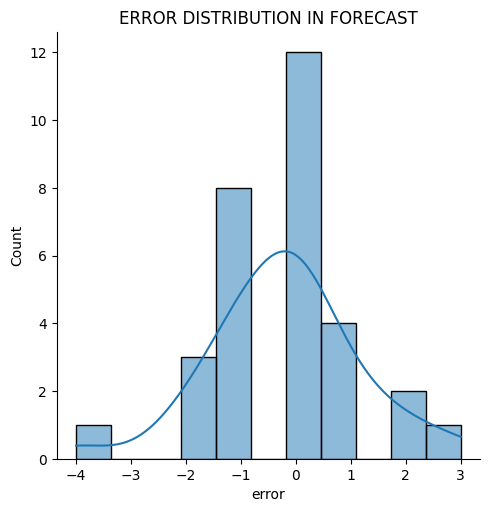

In [492]:
# Mean Square Error & Mean Absolute Error
mse = mean_squared_error(test['accident_count'], test['forecast'])
mae = mean_absolute_error(test['accident_count'], test['forecast'])

print(f"Mean Squared Error (MSE):  {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# residual plot
sns.displot(test['error'],kde=True)
plt.title('ERROR DISTRIBUTION IN FORECAST')

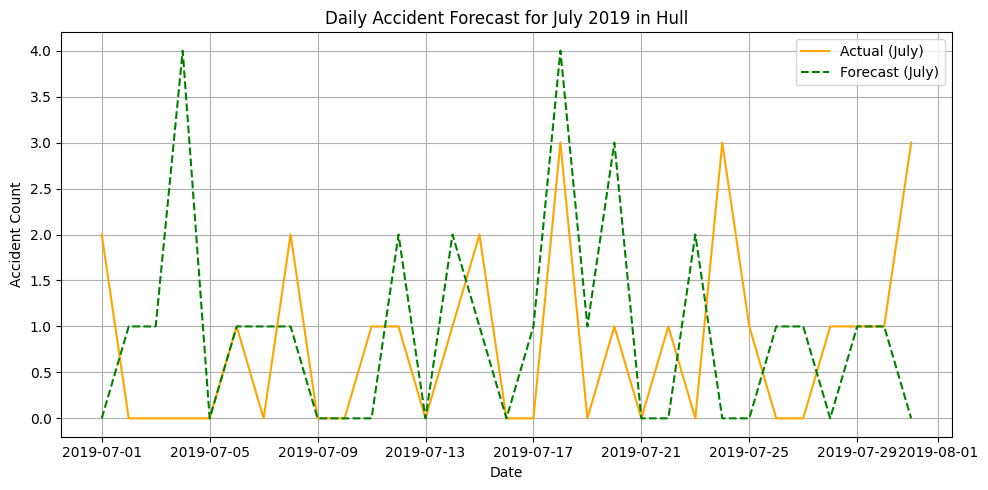

In [507]:
# Plot Forecast vs Actual

plt.figure(figsize=(10, 5))
#plt.plot(train.index, train['accident_count'], label='Train', color='blue')
plt.plot(test.index, test['accident_count'], label='Actual (July)', color='orange')
plt.plot(test.index, test['forecast'], label='Forecast (July)', color='green', linestyle='--')
plt.title('Daily Accident Forecast for July 2019 in Hull')
plt.xlabel('Date')
plt.ylabel('Accident Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()